# Загрузка Pandas и очистка данных

In [1]:
import numpy as np  # для работы с массивами
import pandas as pd  # для работы DataFrame
import seaborn as sns  # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt  # для построения графиков
from ast import literal_eval  # для преобразования списков
import re  # для регулярных выражений

In [2]:
# для распознования тональности отзывов
import textblob
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

In [3]:
df = pd.read_csv('main_task_new.csv')

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

    Restaurant_id — идентификационный номер ресторана / сети ресторанов;
    City — город, в котором находится ресторан;
    Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
    Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
    Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
    Price Range — диапазон цен в ресторане;
    Number of Reviews — количество отзывов о ресторане;
    Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
    URL_TA — URL страницы ресторана на TripAdvisor;
    ID_TA — идентификатор ресторана в базе данных TripAdvisor.


In [4]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

# Функции

In [5]:
# Функция для замены символов на целые числа:
def price_range_cod(x):
    if x == "$":
        return 1
    elif x == "$$ - $$$":
        return 2
    else:
        return 3

In [6]:
# Функция для заполнения столбцов с датами отзывов:
def func(row):
    if len(row['Reviews Date']) == 2:
        return row['Reviews Date'][0], row['Reviews Date'][1]
    elif len(row['Reviews Date']) == 1:
        return row['Reviews Date'][0], np.nan
    else:
        return np.nan,np.nan

In [7]:
# Функция для заполнения столбца с разницей в днях между последним отзывом и сегодняшней датой:
def days(day_1, day_2):
    date_td = pd.datetime.today()
    if not day_1 or not day_2:
        return 0
    if day_1 > day_2:
        return (date_td - pd.to_datetime(day_1)).days
    return (date_td - pd.to_datetime(day_2)).days


In [8]:
# Функция для определения полярности отзыва:
def find_pol(review):
    return TextBlob(review).sentiment.polarity

In [9]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
4634,id_1112,Krakow,NaN,1113.0,3.5,NaN,3.0,[['We spend money in here and still have to p....,/Restaurant_Review-g274772-d8723774-Reviews-Kl...,d8723774
16109,id_14557,London,"['Italian', 'Pizza']",14568.0,3.5,$$ - $$$,31.0,"[['typical Pizza express, a bit tired decor', ...",/Restaurant_Review-g186338-d734336-Reviews-Piz...,d734336
2954,id_3396,Paris,"['Lebanese', 'Mediterranean', 'Middle Eastern']",3397.0,4.5,$$ - $$$,65.0,"[[""The best falafel I've ever tasted"", 'Great ...",/Restaurant_Review-g187147-d5539708-Reviews-Re...,d5539708
12413,id_1192,Lyon,"['French', 'Spanish', 'Wine Bar']",1193.0,4.0,$$ - $$$,31.0,[['Great and cizy place to be for lovely col.....,/Restaurant_Review-g187265-d7991155-Reviews-L_...,d7991155
8031,id_1566,Rome,"['Italian', 'Seafood', 'Mediterranean']",1567.0,4.5,$,110.0,"[['Good place, food, wine and all.', 'Best win...",/Restaurant_Review-g187791-d6715617-Reviews-Lo...,d6715617


In [10]:
df.info()  # посмотрим общую информацию по датасету

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [11]:
df.nunique(dropna=False)  # посмотрим уникальносить признаков

Restaurant_id        11909
City                    31
Cuisine Style         9008
Ranking              11936
Rating                   9
Price Range              4
Number of Reviews     1460
Reviews              33516
URL_TA               39980
ID_TA                39980
dtype: int64

# Работа с пропусками и преобразование данных



 ## Price Range

In [12]:
# убираем пропуски из столбца с уровнем цен, заполняя их модой:
df['Price Range'] = df['Price Range'].fillna(df['Price Range'].mode()[0])

In [13]:
# заменим буквы в рейтинге цен на цифры от 1(самый дешевый) до 3 (самый дорогой):
df['Price Range'] = df['Price Range'].apply(price_range_cod)

In [14]:
df.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
34824,id_2881,London,"['Italian', 'Bar', 'Pizza', 'Vegetarian Friend...",2886.0,3.5,2,407.0,"[['Not my greatest Bunga experience', 'Fun nig...",/Restaurant_Review-g186338-d2478020-Reviews-Bu...,d2478020
11717,id_1695,Athens,NaN,1697.0,3.5,2,6.0,"[[], []]",/Restaurant_Review-g189400-d10643612-Reviews-V...,d10643612
32752,id_6900,Barcelona,['French'],6901.0,3.0,2,NaN,"[['Bar Cafetiere J.B, Barcelona'], ['10/01/201...",/Restaurant_Review-g187497-d5877986-Reviews-Ce...,d5877986


 ## Restaurant_id

In [15]:
# Перед заполнением пропусков добавим столбец с количеством ресторанов с одинаковым id и назовем его 'Restaurant Chain'
# группируем данные по id ресторана, считаем кол-во ресторанов в каждой сети
df_id = df[['Restaurant_id']].value_counts()
df_id = df_id.to_frame().reset_index()  # преобразуем в ДФ
# прописываем названия столбцов
df_id.columns = ['Restaurant_id', 'Restaurant Chain']
# через мердж добавляем столбец с количеством ресторанов в сети
df = df.merge(df_id, how='left', on=['Restaurant_id'])

## Number of Reviews

In [16]:
# убираем пропуски из столбца с отзывами, заполняя их модой по городам  
df['Number of Reviews'] = df.groupby('City')['Number of Reviews'].transform(lambda x: x.fillna(x.mode()[0]))

## Cuisine Style

В столбце с кухнями встречается много пропусков. Пропуски можно заполнить неизвестной кухней, например "Other"  и затем подсчитать количество видов кухонь по каждому ресторану в дополнительном столбце "Number of Cuisines". Или можно заполнить модой, группируя значения по столбцу с количеством сетевых ресторанов вариант 2. Используем второй вариант.


вариант 1

df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")  # заполнили пропуски

df['Cuisine Style'] = df['Cuisine Style'].apply(literal_eval)  # преобразовали строку в список

df['Number of Cuisines'] = df['Cuisine Style'].apply(len) # добавили столбец с количеством кухонь в каждом ресторане:

df.head(5)

в этом случае количество ресторанов с одним видом кухонь на 72 больше, чем при втором варианте, проэтому выбираем вариант 2

In [17]:
# вариант 2
df['Cuisine Style'] = df.groupby('Restaurant Chain')['Cuisine Style'].\
    transform(lambda x: x.fillna(x.mode()[0])) # заполнили пропуски модой в каждом городе кухонь
df['Cuisine Style'] = df['Cuisine Style'].apply(literal_eval) # преобразовали строку в список 
df['Number of Cuisines'] = df['Cuisine Style'].apply(len) # добавили столбец с количеством кухонь в каждом ресторане
df.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Restaurant Chain,Number of Cuisines
8041,id_1118,Warsaw,[Italian],1120.0,5.0,2,2.0,"[[], []]",/Restaurant_Review-g274856-d12921238-Reviews-P...,d12921238,5,1
9296,id_6870,Barcelona,[French],6871.0,3.0,2,2.0,"[[], []]",/Restaurant_Review-g187497-d10673544-Reviews-P...,d10673544,1,1


# Анализ данных и создание новых признаков

## Reviews

Столбец содержит информацию двух видов: текст и даты. Создадим на его основе стобцы, характерезующие временные интервалы и столбец, определяющий тональность отзовов

In [18]:
df['Reviews'][0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [19]:
# из столбца с отзывами выделим столбец с датами отзывов 
pattern = re.compile('\'\d+\/\d+\/\d+\'?')
df['Reviews Date'] = df['Reviews'].apply(pattern.findall)
df['Reviews Date'] = df['Reviews Date'].apply(lambda x: sorted([pd.to_datetime(i).date() for i in x]))

In [20]:
# добавим два столбца (даты двух отзывов), используя функцию func:
df[['date_1', 'date_2']] = df[['Reviews Date']].apply(func, axis=1, result_type='expand')

In [21]:
df.sample(2)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Restaurant Chain,Number of Cuisines,Reviews Date,date_1,date_2
22583,id_6301,Barcelona,"[Brew Pub, Pizza, Pub]",6302.0,4.0,2,5.0,"[['Great Tasting food'], ['02/08/2016']]",/Restaurant_Review-g187497-d9853747-Reviews-Eu...,d9853747,1,3,[2016-02-08],2016-02-08,NaN
24747,id_1307,Rome,"[Middle Eastern, Afghani, Vegetarian Friendly]",1308.0,4.0,1,145.0,[['amazing!! an unexpected surprise in Marcon....,/Restaurant_Review-g187791-d10049096-Reviews-R...,d10049096,7,3,"[2017-03-05, 2017-07-25]",2017-03-05,2017-07-25


In [22]:
# Заполним пропуски в столбцах с датами отзывов модой по ресторанным сетям:
df['date_1'] = df.groupby('Restaurant Chain')['date_1'].\
    transform(lambda x: x.fillna(x.mode()[0]))   

df['date_2'] = df.groupby('Restaurant Chain')['date_2'].\
    transform(lambda x: x.fillna(x.mode()[0]))  

In [23]:
# Добавим столбец - разница в днях между двумя отзывами:
df['Date Delta'] = df['date_2'] - df['date_1']
df['Date Delta'] = df['Date Delta'].dt.days

In [24]:
df.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Restaurant Chain,Number of Cuisines,Reviews Date,date_1,date_2,Date Delta
16828,id_2512,Milan,[Italian],2514.0,4.0,2,53.0,"[['good food', 'Good dining in lovely place!']...",/Restaurant_Review-g187849-d11828586-Reviews-M...,d11828586,5,1,"[2017-03-13, 2017-09-28]",2017-03-13,2017-09-28,199


In [25]:
# Создадим новый признак  - кол-во дней с последнего отзыва до сегодняшнего дня:
df['Delta Today'] = df[['date_1', 'date_2']].apply(
    lambda x: days(*x), axis=1)
df.sample()

<ipython-input-7-e4a4da95eb05>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_td = pd.datetime.today()


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Restaurant Chain,Number of Cuisines,Reviews Date,date_1,date_2,Date Delta,Delta Today
27501,id_444,Lisbon,"[Bar, Pub, European]",445.0,4.5,2,59.0,"[['Good variety. Waitress not knowledgeable', ...",/Restaurant_Review-g189158-d12112773-Reviews-D...,d12112773,12,3,"[2018-02-15, 2018-02-23]",2018-02-15,2018-02-23,8,1335


In [26]:
# добавляем столбец с полярностью отзывов
df['Sentiment Polarity'] = df['Reviews'].apply(find_pol)
df.head() 

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Restaurant Chain,Number of Cuisines,Reviews Date,date_1,date_2,Date Delta,Delta Today,Sentiment Polarity
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3,"[2017-11-20, 2017-12-31]",2017-11-20,2017-12-31,41,1389,0.700000
1,id_1535,Stockholm,[Italian],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,1,"[2016-06-19, 2017-07-06]",2016-06-19,2017-07-06,382,1567,0.687500
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8,7,"[2018-01-06, 2018-01-08]",2018-01-06,2018-01-08,2,1381,-0.333333
3,id_3456,Berlin,[Italian],3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,4,1,[],2017-11-05,2018-01-07,63,1382,0.000000
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,14,3,"[2017-02-19, 2017-11-18]",2017-02-19,2017-11-18,272,1432,0.800000


<AxesSubplot:xlabel='Rating', ylabel='Sentiment Polarity'>

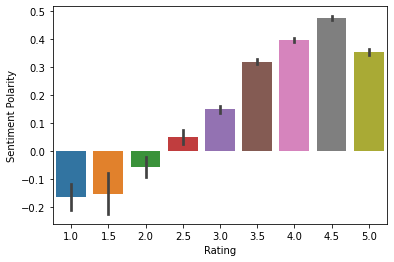

In [27]:
# построим среднюю полярность для каждого балла рейтинга:
sns.barplot(x='Rating', y='Sentiment Polarity', data=df) 

<AxesSubplot:>

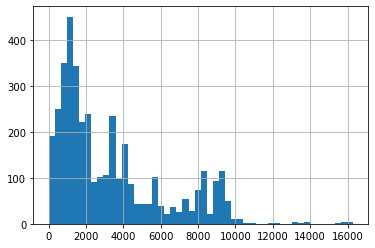

In [28]:
# Посмотрим распределение целевой переменной относительно признака:
df['Ranking'][df['Rating'] == 5].hist(bins=50)

Распределение похоже на нормальное, но попробуем его улучшить с помощью новых признаков. Для этого создадим столбец с количеством ресторанов в каждом городе

In [29]:
df1=df[['City']].value_counts() # группируем данные по гороодам, считаем кол-во ресторанов в каждом городе
df1 = df1.to_frame().reset_index() # преобразуем в ДФ
df1.columns=['City', 'Number of Restaurants'] # прописываем названия столбцов
df = df.merge(df1, how='left', on=['City']) # через мердж добавляем столбец с количеством городов в основной ДФ
df.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Restaurant Chain,Number of Cuisines,Reviews Date,date_1,date_2,Date Delta,Delta Today,Sentiment Polarity,Number of Restaurants
31459,id_1908,Lyon,[Italian],1909.0,3.5,2,13.0,"[[], []]",/Restaurant_Review-g187265-d5800729-Reviews-Le...,d5800729,8,1,[],2018-01-03,2018-01-08,5,1381,0.0,892


In [30]:
# Добавим новый признак 'Delta Ranking Index':
df['Delta_ranking']=df['Number of Restaurants'] - df['Ranking']
df['Delta Ranking Index'] = df['Delta_ranking']/df['Number of Restaurants']
df

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Number of Cuisines,Reviews Date,date_1,date_2,Date Delta,Delta Today,Sentiment Polarity,Number of Restaurants,Delta_ranking,Delta Ranking Index
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,...,3,"[2017-11-20, 2017-12-31]",2017-11-20,2017-12-31,41,1389,0.700000,4897,-673.0,-0.137431
1,id_1535,Stockholm,[Italian],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,...,1,"[2016-06-19, 2017-07-06]",2016-06-19,2017-07-06,382,1567,0.687500,820,-717.0,-0.874390
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,...,7,"[2018-01-06, 2018-01-08]",2018-01-06,2018-01-08,2,1381,-0.333333,5757,5404.0,0.938683
3,id_3456,Berlin,[Italian],3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,...,1,[],2017-11-05,2018-01-07,63,1382,0.000000,2155,-1303.0,-0.604640
4,id_615,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,...,3,"[2017-02-19, 2017-11-18]",2017-02-19,2017-11-18,272,1432,0.800000,893,272.0,0.304591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,2,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,...,4,"[2017-11-12, 2017-12-16]",2017-11-12,2017-12-16,34,1404,0.666667,2133,1633.0,0.765588
39996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,...,5,"[2017-12-12, 2017-12-21]",2017-12-12,2017-12-21,9,1399,0.600000,4897,-1444.0,-0.294874
39997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,4.5,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,...,2,"[2008-04-12, 2016-11-03]",2008-04-12,2016-11-03,3127,1812,0.177778,820,-832.0,-1.014634
39998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,...,5,"[2017-06-18, 2017-07-11]",2017-06-18,2017-07-11,23,1562,0.000000,727,86.0,0.118294


<AxesSubplot:>

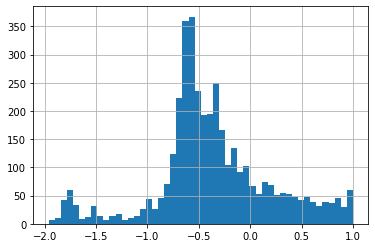

In [31]:
# Посмотрим распределение целевой переменной относительно признака:
df['Delta Ranking Index'][df['Rating'] == 5].hist(bins=50)

Новый признак лучше коррелирует с целевой переменной

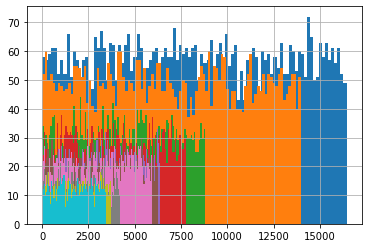

In [32]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

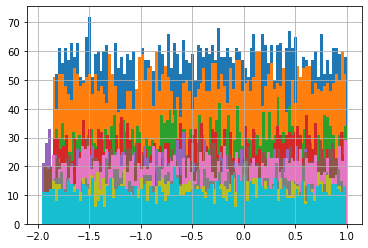

In [33]:
for x in (df['City'].value_counts())[0:10].index:
    df['Delta Ranking Index'][df['City'] == x].hist(bins=100)
plt.show()

## Добавим внешние данные для характеристики городов 

In [34]:
# добавим внешние данные(информацию по городу: столица или нет, плотность населения,
# индекс стоимости жизни в городе, индекс цен в ресторанах)
df2 = pd.read_excel('city_info.xlsx').dropna(
    axis=1).drop(['Number of Restaurants'], axis=1)
df = df.merge(df2, how='left', on=['City'])
df.sample()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,Delta Today,Sentiment Polarity,Number of Restaurants,Delta_ranking,Delta Ranking Index,State,Population Density,Cost of Living Index,Restaurant Price Index,Tourizm 2018
10459,id_3851,Barcelona,"[Mediterranean, European, Spanish, Gluten Free...",3852.0,3.5,2,229.0,"[['Caters to Large Groups', 'Enjoyable'], ['10...",/Restaurant_Review-g187497-d3138524-Reviews-Cu...,d3138524,...,1462,0.357143,2734,-1118.0,-0.408925,0,16642,62.15,67.16,6714.5


Посмотрим на кореляцию полученых признаков и целевой переменной

In [35]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Ranking,Rating,Price Range,Number of Reviews,Restaurant Chain,Number of Cuisines,Date Delta,Delta Today,Sentiment Polarity,Number of Restaurants,Delta_ranking,Delta Ranking Index,State,Population Density,Cost of Living Index,Restaurant Price Index,Tourizm 2018
Ranking,1.00,-0.37,-0.03,-0.22,-0.76,-0.32,0.14,0.12,-0.21,0.71,-0.88,-0.55,0.22,0.29,0.19,0.24,0.66
Rating,-0.37,1.00,-0.03,0.03,0.29,0.12,-0.08,-0.07,0.27,-0.06,0.46,0.54,0.02,-0.06,-0.03,-0.05,-0.02
Price Range,-0.03,-0.03,1.00,0.11,0.04,0.00,-0.01,-0.02,-0.03,0.01,0.04,0.05,0.00,0.04,0.07,0.06,-0.00
Number of Reviews,-0.22,0.03,0.11,1.00,0.25,0.41,-0.15,-0.11,0.14,0.03,0.32,0.41,0.00,-0.00,-0.01,0.02,0.05
Restaurant Chain,-0.76,0.29,0.04,0.25,1.00,0.35,-0.15,-0.09,0.21,-0.59,0.63,0.53,-0.17,-0.26,-0.07,-0.12,-0.52
Number of Cuisines,-0.32,0.12,0.00,0.41,0.35,1.00,-0.25,-0.15,0.24,-0.03,0.42,0.54,0.02,-0.09,0.00,0.02,0.01
Date Delta,0.14,-0.08,-0.01,-0.15,-0.15,-0.25,1.00,0.07,-0.01,-0.02,-0.20,-0.25,-0.02,0.04,-0.00,-0.02,-0.03
Delta Today,0.12,-0.07,-0.02,-0.11,-0.09,-0.15,0.07,1.00,0.06,0.01,-0.15,-0.18,0.02,0.02,0.02,0.01,0.02
Sentiment Polarity,-0.21,0.27,-0.03,0.14,0.21,0.24,-0.01,0.06,1.00,0.00,0.29,0.37,0.02,-0.02,0.03,0.03,0.03
Number of Restaurants,0.71,-0.06,0.01,0.03,-0.59,-0.03,-0.02,0.01,0.00,1.00,-0.28,0.02,0.32,0.41,0.26,0.34,0.93


In [36]:
# удалим признаки 'Number of Restaurants', 'Delta_ranking' поскольку у нас есть новый признак Delta Ranking Index
df=df.drop(['Number of Restaurants', 'Delta_ranking'], axis = 1)

In [37]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,...,date_2,Date Delta,Delta Today,Sentiment Polarity,Delta Ranking Index,State,Population Density,Cost of Living Index,Restaurant Price Index,Tourizm 2018
9573,id_1583,Copenhagen,[Italian],1586.0,4.0,2,3.0,"[['Meal along the way'], ['03/03/2017']]",/Restaurant_Review-g189541-d10284879-Reviews-S...,d10284879,...,2018-01-07,310,1382,0.000000,-1.406677,1,9023,97.91,113.18,3069.7
2839,id_3186,Prague,"[Bar, European, Czech, Central European, Pub]",3193.0,3.5,2,56.0,"[['OK choice for a lunch', 'Nothing special'],...",/Restaurant_Review-g274707-d3196515-Reviews-Av...,d3196515,...,2017-10-18,25,1463,0.428571,-1.212751,1,2692,48.02,37.83,8948.6
8365,id_416,Prague,"[European, Central European, Bar, Mediterranea...",417.0,4.5,2,64.0,"[['Superb Tea and Coffee', 'Good place to rela...",/Restaurant_Review-g274707-d10171171-Reviews-B...,d10171171,...,2017-11-09,24,1441,0.850000,0.711019,1,2692,48.02,37.83,8948.6
9907,id_382,Dublin,"[Irish, Seafood, European, Soups, Gluten Free ...",383.0,4.0,3,547.0,"[['Lovely meal', 'Great dinner...old fashioned...",/Restaurant_Review-g186605-d1177586-Reviews-Th...,d1177586,...,2017-11-16,2,1434,0.650000,0.430906,1,9942,80.28,87.98,5213.4
36613,id_892,Hamburg,[French],894.0,4.0,2,17.0,"[['Nice summeer terrace for lunch', 'Little Ge...",/Restaurant_Review-g187331-d8656712-Reviews-Lu...,d8656712,...,2017-08-05,171,1537,0.206250,0.057956,0,2444,72.15,70.09,1450.0


In [38]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Ranking,Rating,Price Range,Number of Reviews,Restaurant Chain,Number of Cuisines,Date Delta,Delta Today,Sentiment Polarity,Delta Ranking Index,State,Population Density,Cost of Living Index,Restaurant Price Index,Tourizm 2018
Ranking,1.00,-0.37,-0.03,-0.22,-0.76,-0.32,0.14,0.12,-0.21,-0.55,0.22,0.29,0.19,0.24,0.66
Rating,-0.37,1.00,-0.03,0.03,0.29,0.12,-0.08,-0.07,0.27,0.54,0.02,-0.06,-0.03,-0.05,-0.02
Price Range,-0.03,-0.03,1.00,0.11,0.04,0.00,-0.01,-0.02,-0.03,0.05,0.00,0.04,0.07,0.06,-0.00
Number of Reviews,-0.22,0.03,0.11,1.00,0.25,0.41,-0.15,-0.11,0.14,0.41,0.00,-0.00,-0.01,0.02,0.05
Restaurant Chain,-0.76,0.29,0.04,0.25,1.00,0.35,-0.15,-0.09,0.21,0.53,-0.17,-0.26,-0.07,-0.12,-0.52
Number of Cuisines,-0.32,0.12,0.00,0.41,0.35,1.00,-0.25,-0.15,0.24,0.54,0.02,-0.09,0.00,0.02,0.01
Date Delta,0.14,-0.08,-0.01,-0.15,-0.15,-0.25,1.00,0.07,-0.01,-0.25,-0.02,0.04,-0.00,-0.02,-0.03
Delta Today,0.12,-0.07,-0.02,-0.11,-0.09,-0.15,0.07,1.00,0.06,-0.18,0.02,0.02,0.02,0.01,0.02
Sentiment Polarity,-0.21,0.27,-0.03,0.14,0.21,0.24,-0.01,0.06,1.00,0.37,0.02,-0.02,0.03,0.03,0.03
Delta Ranking Index,-0.55,0.54,0.05,0.41,0.53,0.54,-0.25,-0.18,0.37,1.00,0.00,0.01,-0.00,0.00,0.02


У нас есть признаки признаки, коррелирующие между собой, но удалять их не будет, т.к. в ходе экспериментов их удаление снижает точность расчетов .

## Dummpy- переменные

Добавим Dummpy- переменные по видам кухонь и городам

In [39]:
df3 = pd.get_dummies(df['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, df3], axis=1)

In [40]:
df4 = pd.get_dummies(df['City'].apply(pd.Series).stack()).sum(level=0)
df = pd.concat([df, df4], axis=1)

In [41]:
# удаляем неколичественные признаки:
df=df.drop(['City', 'Cuisine Style','Reviews', 'URL_TA', 'ID_TA', 'Reviews Date','date_1', 'date_2'], axis = 1)

In [42]:
df.sample(5)

,Restaurant_id,Ranking,Rating,Price Range,Number of Reviews,Restaurant Chain,Number of Cuisines,Date Delta,Delta Today,Sentiment Polarity,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
2157,id_356,357.0,4.0,2,9.0,12,1,214,2024,0.60,...,0,0,0,0,0,0,0,0,0,0
24271,id_7569,7570.0,2.0,2,9.0,1,1,274,1571,-0.35,...,0,0,0,0,0,0,0,0,0,0
5155,id_9731,9733.0,5.0,2,4.0,1,1,1262,1397,1.00,...,0,0,0,1,0,0,0,0,0,0
13398,id_731,732.0,4.5,2,23.0,9,1,14,2127,0.85,...,0,1,0,0,0,0,0,0,0,0
7496,id_219,220.0,3.5,2,101.0,8,3,38,1408,0.91,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Columns: 172 entries, Restaurant_id to Zurich
dtypes: float64(8), int64(7), object(1), uint8(156)
memory usage: 12.1+ MB


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [51]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
y = df['Rating']

In [52]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [53]:
# Наборы данных сметкой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [54]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [55]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [56]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20179950000000002


<AxesSubplot:>

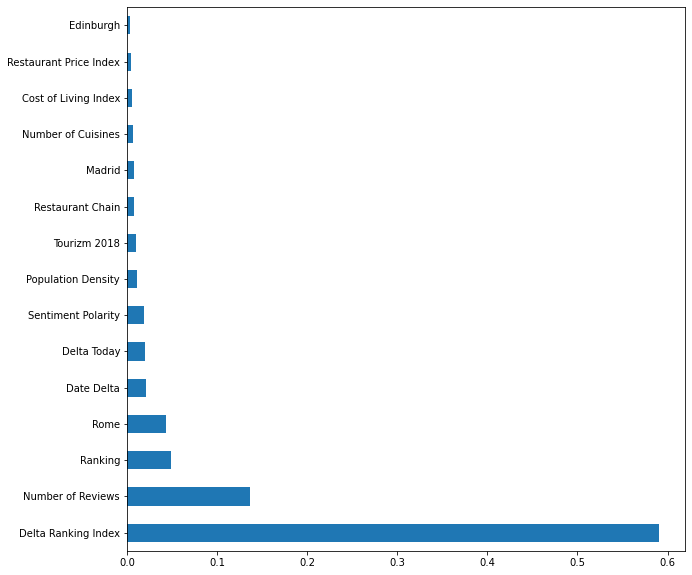

In [57]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')